# CLUSTERING TECHNIQUES

## USE OF DATASETS WITH GROUND TRUTH FOR COMPARING THE DIFFERENT TECHNIQUES

### FIRST DATASET - REUTERS NEWS - A BASELINE DATASET WITH ONLY TWO LABELS (GROUND TRUTH K=2)

In [41]:
import pandas as pd

#load the dataset
dataset_filepath = 'datasets/IMDB_Dataset_Sentiment.csv'
initial_df = pd.read_csv(dataset_filepath)
df_cols = initial_df.columns.to_list()
print(f'The length of the dataset is: {len(initial_df)}')
print(df_cols)

The length of the dataset is: 50000
['review', 'sentiment']


### CREATE THE NECESSARY UTILS FOR PREPARING THE DATA

In [42]:
import pandas as pd
from langdetect import detect, DetectorFactory
from collections import Counter

# keep a sample of our dataset
df = initial_df.sample(1000)
#define the length of the dataset
length_of_data = len(df)
# define the column which contains the comments
text_col = 'review'

# ensure consistent results across different runs
DetectorFactory.seed = 0

# function to detect language of each entry
def detect_language(text):
    """
    Detect the most common language in a text
    :param text: the text to be detected 
    :return: the language of the text
    """
    try:
        return detect(text)
    except:
        # Handle crazy cases where detection fails
        return "unknown"

# apply the language detection function to each row
df['language'] = df[text_col].apply(detect_language)

# find the most common language in the dataset
most_common_lang = Counter(df['language']).most_common(1)[0][0]

# assign the most common language to the variable
lang_of_dataset = most_common_lang

print(f"The language of the dataset is: {lang_of_dataset}")

The language of the dataset is: en


In [44]:
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import FastText

# load the proper model based on the language of the dataset
if lang_of_dataset == 'el':
    name_of_pretrained_model = 'el_core_news_sm'
else:
    name_of_pretrained_model = 'en_core_web_sm'

nlp = spacy.load(name_of_pretrained_model)

def tokenizer(document):
    """
    Tokenizer who removes punctuation
    :param document: string which is a text
    :return: tokenized text
    """
    return [token.text for token in nlp(document) if not token.is_space]

# Initialize TfidfVectorizer with the Greek tokenizer
vectorizer_news = TfidfVectorizer(
    tokenizer=tokenizer,       # Custom tokenizer
    max_df=0.9,                # Ignore terms that appear in more than 80% of documents
    min_df=5,                  # Ignore terms that appear in fewer than 5 documents
    max_features=20000,        # Limit to the top 20,000 features
    stop_words='english'       # Optional: Remove common English stop words
)
transformed_data_tfidf = vectorizer.fit_transform(df[text_col].tolist())
print('Comments transformed successfully via TF-IDF vectorizer')

# Create a pretrained model with FastText
model = FastText(sentences=initial_df[text_col], vector_size=256, window=10, min_count=1, workers=4)
transformed_data_fasttext = np.array([model.wv.get_mean_vector(comment) for comment in df[text_col]])
print('Comments transformed successfully via pretrained FastText language model')

Comments transformed successfully via TF-IDF vectorizer
Comments transformed successfully via pretrained FastText language model


### 1ST CLUSTERING TECHNIQUE: KMEANS

We are going to implement the original KMeans without using any constraints. For transforming the data we are going to use TF-IDF and FastText embeddings.

#### USING TF-IDF VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:07<00:00,  2.55s/it]

The optimum kappa based on Silhouette score is: 2


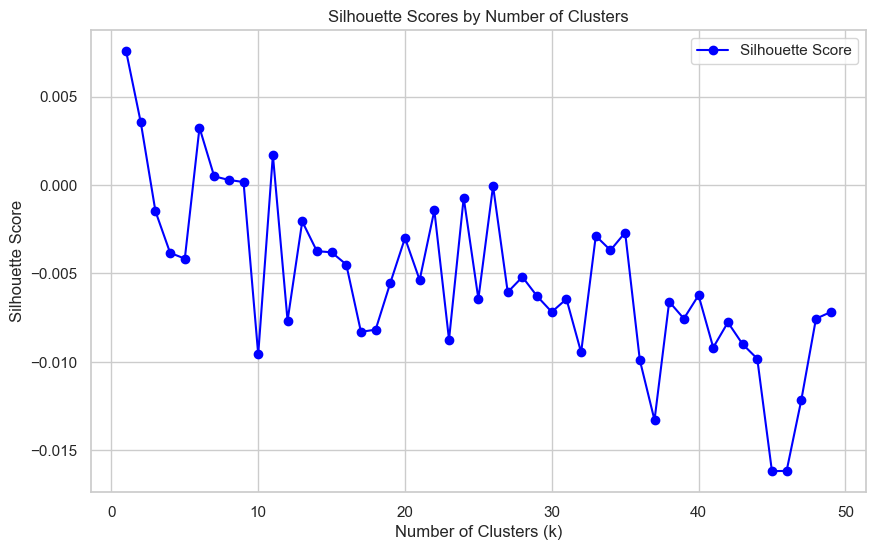

In [46]:
from clustering_algorithms.kmeans import calc_kmeans
max_num_of_clusters = 50
labels = df['sentiment'].to_list()

# calculate the optimun kappa with KMeans via Silhouette score and using TF-IDF
kappa_kmeans_tfidf, scores_kmeans_tfidf, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(transformed_data_tfidf, max_num_of_clusters, labels)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.28it/s]

The optimum kappa based on Silhouette score is: 2


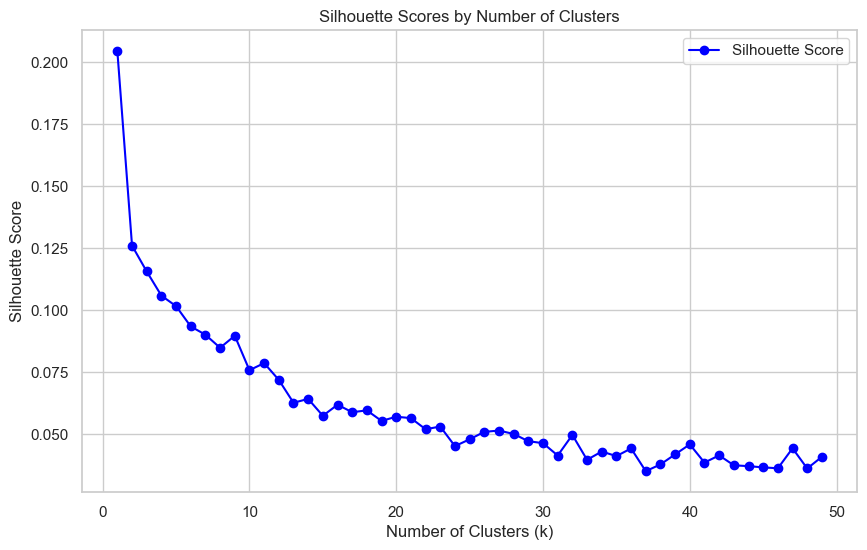

In [52]:
from clustering_algorithms.kmeans import calc_kmeans
max_num_of_clusters = 50
labels = df['sentiment'].to_list()
# calculate the optimun kappa with KMeans via Silhouette score and using FastText
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(transformed_data_fasttext, max_num_of_clusters, true_labels=labels)

In [59]:
# Assuming statistic_values_ami is the list containing AMI scores
max_ami_index = np.argmax(statistic_values_nmi)

print(f'The index of the maximum AMI score is: {max_ami_index}')
print(f'The maximum AMI score is: {statistic_values_nmi[max_ami_index]}')

The index of the maximum AMI score is: 42
The maximum AMI score is: 0.01946152992453574


### 2ND CLUSTERING TECHNIQUE: KMEANS CONSTRAINED (DEFINE MIN SIZE OF CLUSTERS)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND TF-IDF VECTORIZATION

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [44:37<00:00, 26.78s/it]


The optimum kappa based on Silhouette score is: 2


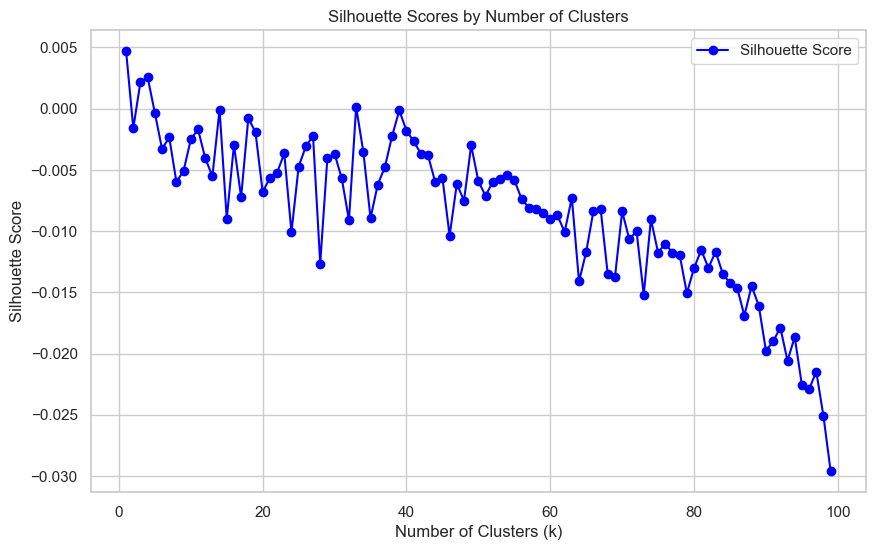

In [4]:
from clustering_algorithms.kmeans_constrained import get_number_of_clusters_with_statistic_constrained
max_num_of_clusters = 100

# calculate the optimun kappa with KMeans Constrained via Silhouette score and using TF-IDF
kappa_kmeans_cv_silhouette_tfidf, scores_kmeans_cv_silhouette_tfidf = get_number_of_clusters_with_statistic_constrained(
    transformed_data_tfidf, max_num_of_clusters, statistic_metric='silhouette'
)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND FASTTEXT VECTORIZATION

In [60]:
# calculate the optimun kappa with KMeans Constrained via Silhouette score and using FastText
kappa_kmeans_cv_silhouette_ft, scores_kmeans_cv_silhouette_ft = get_number_of_clusters_with_statistic_constrained(
    transformed_data_fasttext, max_num_of_clusters, statistic_metric='silhouette'
)

NameError: name 'get_number_of_clusters_with_statistic_constrained' is not defined

### 3RD CLUSTERING TECHNIQUE: AGGLOMERATIVE

#### USING TF-IDF VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [02:34<00:00,  3.15s/it]

The optimal number of clusters based on Silhouette score is: 1


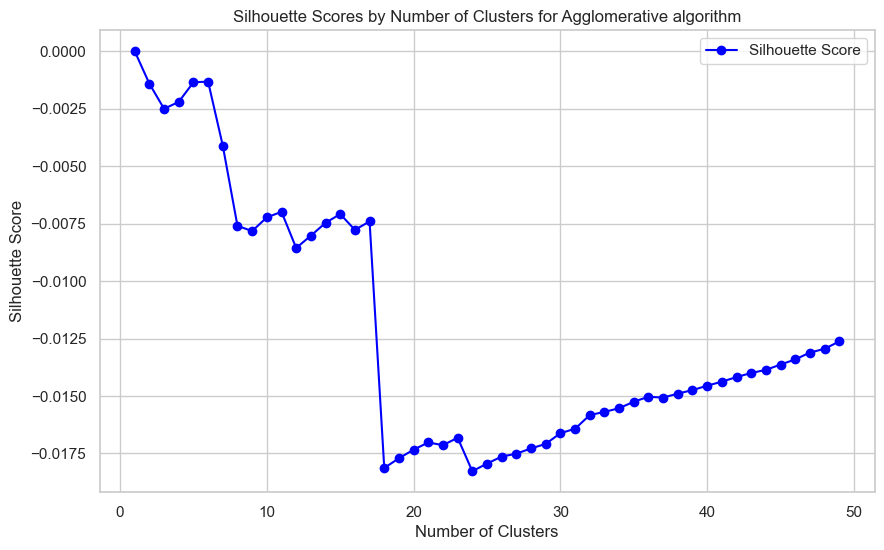

In [63]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,50)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_tfidf, scores_agglomerative_tfidf = calc_agglomerative(transformed_data_tfidf, cluster_values)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:07<00:00, 14.12it/s]


The optimal number of clusters based on Silhouette score is: 2


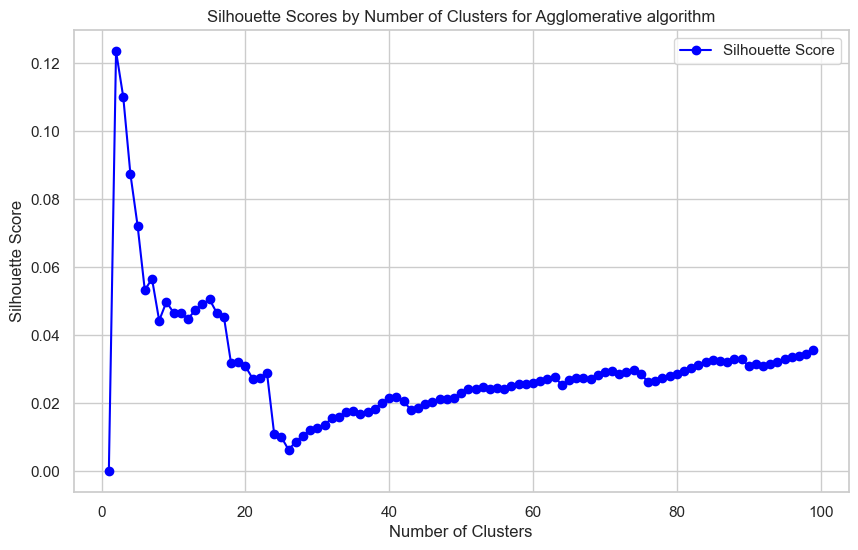

In [62]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_ft, scores_agglomerative_ft = calc_agglomerative(transformed_data_fasttext, cluster_values)

### 4TH CLUSTERING TECHNIQUE: DBSCAN (DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING TF-IDF VECTORIZATION

Suggested eps values:[1.08373218 1.08694555 1.09013128 1.09320133 1.09597954 1.09798219
 1.09988077 1.10251005 1.10374104 1.10696425 1.10890137 1.11110556
 1.1120914  1.11541039 1.11843946 1.12022754 1.1216928  1.12499048
 1.1261166  1.12747263 1.12897392 1.13115295 1.13284597 1.13431365
 1.13520177 1.13664201 1.13847858 1.14067411 1.14155211 1.14272161
 1.14488541 1.14593345 1.14753529 1.14858842 1.15061696 1.15203911
 1.15316719 1.1550506  1.15603603 1.15763365 1.15861427 1.15973323
 1.16077028 1.16149071 1.16212524 1.1630547  1.16384633 1.16511952
 1.16666447 1.16774075 1.16937763 1.17061241 1.17285566 1.17409188
 1.17499315 1.17555046 1.17649574 1.17771143 1.17943737 1.18129243
 1.18370825 1.18510797 1.18622311 1.18702908 1.18818643 1.18951829
 1.19116572 1.19203577 1.19265891 1.19372167 1.19559561 1.19641413
 1.19796246 1.19898807 1.20126307 1.20234631 1.20352532 1.20450335
 1.20578446 1.2075064  1.20930749 1.21008296 1.21130585 1.21237644
 1.21362685 1.21476246 1.21600752 1.21668

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 10.67it/s]

The optimal eps based on Silhouette score is: 1e-05
The number of clusters for optimal eps is: 1


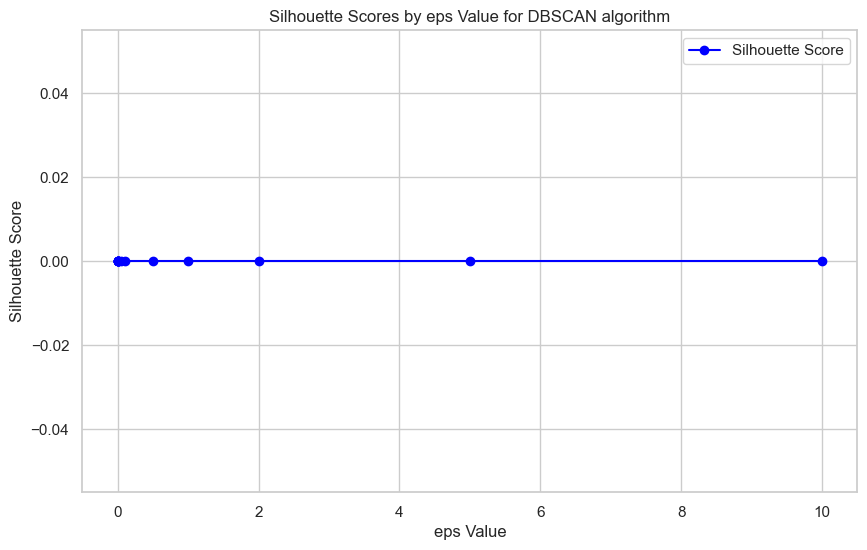

In [22]:
from clustering_algorithms.dbscan import generate_eps_values_via_nearest_neighbors, calc_dbscan

# Generate the best eps values based on the distance of the dataset
eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_tfidf, num_values=100)
eps_values = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_tfidf, kappa_dbscan_tfidf, scores_dbscan_tfidf = calc_dbscan(transformed_data_tfidf, eps_values)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 72.46it/s]


The optimal eps based on Silhouette score is: 0.025
The number of clusters for optimal eps is: 2


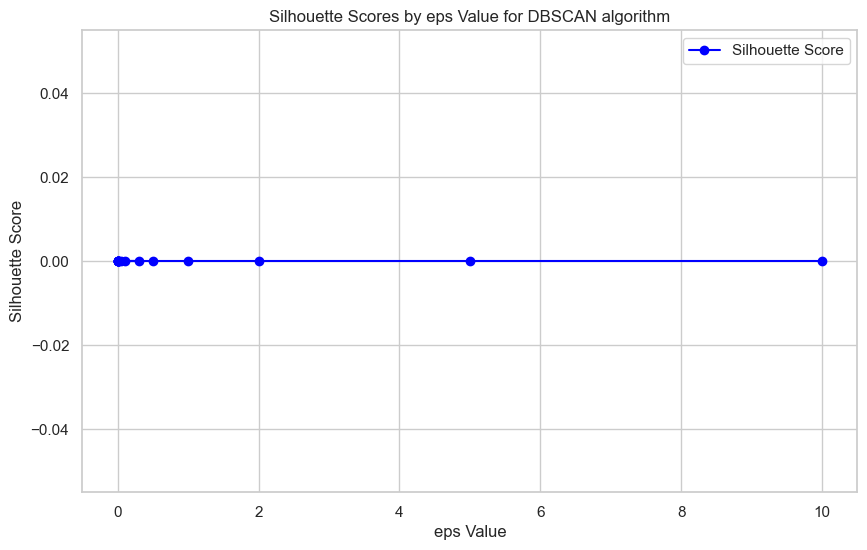

In [28]:
# Generate the best eps values based on the distance of the dataset
# eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_fasttext, num_values=100)
eps_values = [0.025, 0.3, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using FastText
optimal_eps_ft, kappa_dbscan_ft, scores_dbscan_ft = calc_dbscan(transformed_data_fasttext, eps_values)

### LOAD SECOND DATASET - 20NEWSGROUPS - A MORE DIFFICULT DATASET WITH MORE LABELS (GROUND TRUTH K=20)

In [16]:
from sklearn.datasets import fetch_20newsgroups

data_20newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents_20newsgroups = data_20newsgroups.data
labels_20newsgroups = data_20newsgroups.target
labels_names_20newsgroups = data_20newsgroups.target_names
df2_dict = {
    'label': labels_20newsgroups,
    'comment': documents_20newsgroups,
}
df2 = pd.DataFrame(df2_dict)
df2['label_name'] = df2['label'].apply(lambda x: labels_names_20newsgroups[x])
df2_cols = df2.columns.to_list()
print(f'The length of the dataset 20newsgroups is: {len(df2)}')
print(df2_cols)

The length of the dataset 20newsgroups is: 18846
['label', 'comment', 'label_name']


In [17]:
# define the column with the comments
text_col='comment'

# apply the language detection function to each row
df2['language'] = df2[text_col].apply(detect_language)

# find the most common language in the dataset
most_common_lang2 = Counter(df2['language']).most_common(1)[0][0]

# assign the most common language to the variable
lang_of_dataset2 = most_common_lang2

print(f"The language of the dataset is: {lang_of_dataset2}")

The language of the dataset is: en


In [31]:
from sklearn.model_selection import train_test_split

# load the proper model based on the language of the dataset
if lang_of_dataset2 == 'el':
    name_of_pretrained_model2 = 'el_core_news_sm'
else:
    name_of_pretrained_model2 = 'en_core_web_sm'

nlp2 = spacy.load(name_of_pretrained_model2)

x_train_news, x_test_news, y_train_news, y_test_news = train_test_split(
                                                                        df2['comment'], 
                                                                        df2['label'],
                                                                        test_size=0.1,
                                                                        random_state=42,
                                                                        stratify=df2['label'])

x_test_news = x_test_news.reset_index(drop=True)
y_test_news = y_test_news.reset_index(drop=True)
# Find indices of empty comments
empty_indices = [idx for idx, x in enumerate(x_test_news) if len(x.strip()) == 0]
# Drop comments with no text from both x_test_news and y_test_news
x_test_news = x_test_news.drop(empty_indices).reset_index(drop=True)
y_test_news = y_test_news.drop(empty_indices).reset_index(drop=True)
print(f'The final length of the dataset is: {len(x_test_news)}')

# Initialize TfidfVectorizer with the Greek tokenizer
vectorizer_news = TfidfVectorizer(
    tokenizer=tokenizer,       # Custom tokenizer
    max_df=0.9,                # Ignore terms that appear in more than 80% of documents
    min_df=10,                  # Ignore terms that appear in fewer than 5 documents
    max_features=20000,        # Limit to the top 20,000 features
    stop_words='english'       # Optional: Remove common English stop words
)
transformed_data_news_tfidf = vectorizer_news.fit_transform(x_test_news)
print('Comments transformed successfully via TF-IDF vectorizer')

# Create a pretrained model with FastText
model2 = FastText(sentences=df2['comment'].to_list(), vector_size=256, window=10, min_count=1, workers=4)
transformed_data_news_fasttext = np.array([model2.wv.get_mean_vector(comment) for comment in x_test_news])
print('Comments transformed successfully via pretrained FastText language model')

The final length of the dataset is: 1827


C:\1. Python\LLM_mods_Research\venv\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\1. Python\LLM_mods_Research\venv\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt'] not in stop_words.
  warnings.warn(


Comments transformed successfully via TF-IDF vectorizer
Comments transformed successfully via pretrained FastText language model


### 1ST CLUSTERING TECHNIQUE: KMEANS

We are going to implement the original KMeans without using any constraints. For transforming the data we are going to use TF-IDF and FastText embeddings.

#### USING TF-IDF VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.31it/s]

The optimum kappa based on Silhouette score is: 40


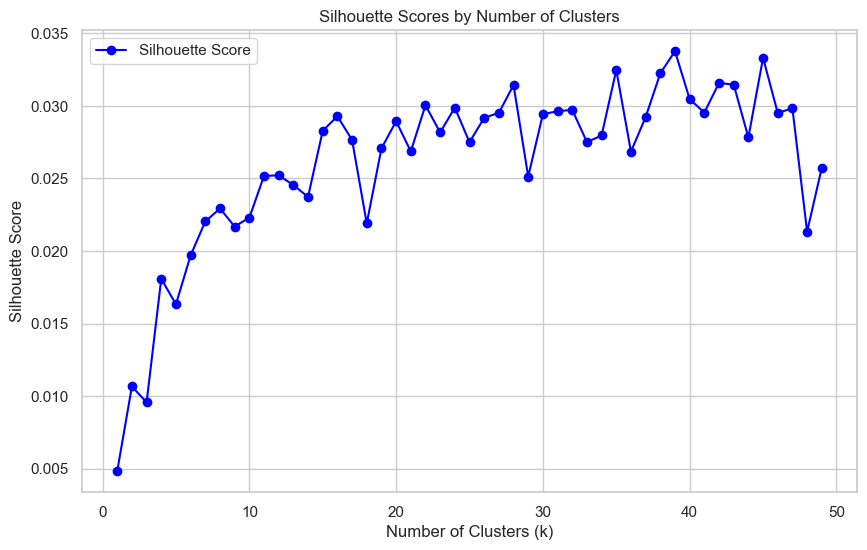

In [32]:
from clustering_algorithms.kmeans import calc_kmeans
max_num_of_clusters = 50

# calculate the optimun kappa with KMeans via Silhouette score and using TF-IDF
kappa2_kmeans_tfidf, scores2_kmeans_tfidf, nmi, ari, ami = calc_kmeans(transformed_data_news_tfidf, max_num_of_clusters, true_labels = y_test_news)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.25it/s]

The optimum kappa based on Silhouette score is: 2


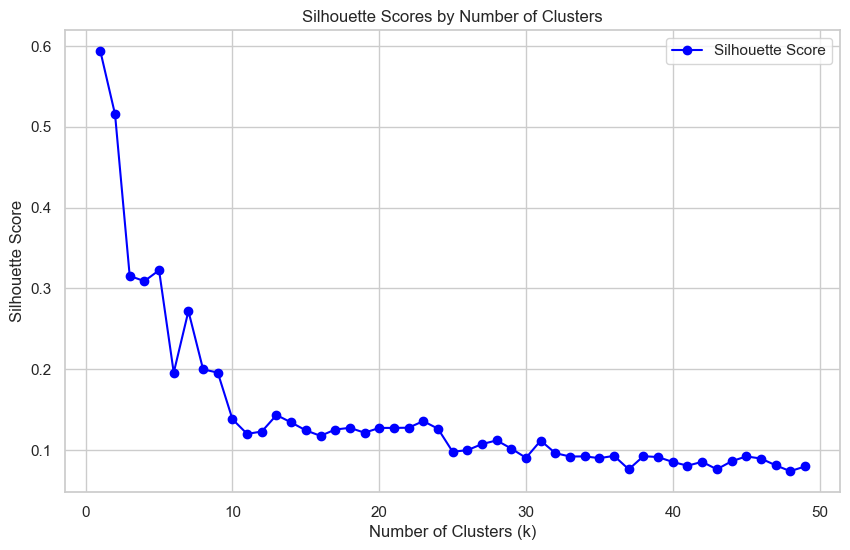

In [33]:
from clustering_algorithms.kmeans import calc_kmeans
max_num_of_clusters = 50

# calculate the optimun kappa with KMeans via Silhouette score and using FastText
kappa2_kmeans_ft, scores_kmeans_ft, nmi, ari, ami = calc_kmeans(transformed_data_news_fasttext, max_num_of_clusters, true_labels = y_test_news)

In [34]:
# Assuming statistic_values_ami is the list containing AMI scores
max_ami_index = np.argmax(ami)
print(f'The index of the maximum AMI score is: {max_ami_index}')
print(f'The maximum AMI score is: {statistic_values_ami[max_ami_index]}')

# Assuming statistic_values_ari is the list containing AMI scores
max_ari_index = np.argmax(ari)
print(f'The index of the maximum ARI score is: {max_ari_index}')
print(f'The maximum ARI score is: {statistic_values_ari[max_ari_index]}')


# Assuming statistic_values_nmi is the list containing AMI scores
max_nmi_index = np.argmax(nmi)
print(f'The index of the maximum NMI score is: {max_nmi_index}')
print(f'The maximum NMI score is: {statistic_values_nmi[max_nmi_index]}')

The index of the maximum AMI score is: 32
The maximum AMI score is: 0.00411850410599001
The index of the maximum ARI score is: 32
The maximum ARI score is: 0.001348323270306365
The index of the maximum NMI score is: 46
The maximum NMI score is: 0.015463078315056467


### 2ND CLUSTERING TECHNIQUE: KMEANS CONSTRAINED (DEFINE MIN SIZE OF CLUSTERS)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND TF-IDF VECTORIZATION

In [ ]:
from clustering_algorithms.kmeans_constrained import get_number_of_clusters_with_statistic_constrained
max_num_of_clusters = 20

# calculate the optimun kappa with KMeans Constrained via Silhouette score and using TF-IDF
kappa_kmeans_cv_silhouette_tfidf, scores_kmeans_cv_silhouette_tfidf = get_number_of_clusters_with_statistic_constrained(
   transformed_data_news_tfidf, max_num_of_clusters, statistic_metric='silhouette'
)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND FASTTEXT VECTORIZATION

In [ ]:
# calculate the optimun kappa with KMeans Constrained via Silhouette score and using FastText
kappa_kmeans_cv_silhouette_ft, scores_kmeans_cv_silhouette_ft = get_number_of_clusters_with_statistic_constrained(
    transformed_data_news_fasttext, max_num_of_clusters, statistic_metric='silhouette'
)

### 3RD CLUSTERING TECHNIQUE: AGGLOMERATIVE

#### USING TF-IDF VECTORIZATION

In [ ]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_tfidf, scores_agglomerative_tfidf = calc_agglomerative(transformed_data_news_tfidf, cluster_values)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:22<00:00,  4.37it/s]

The optimal number of clusters based on Silhouette score is: 2


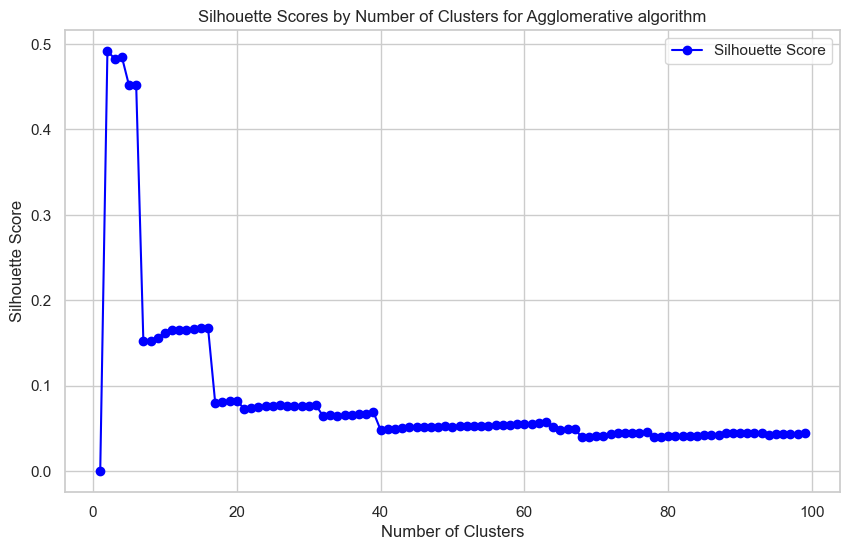

In [66]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_ft, scores_agglomerative_ft = calc_agglomerative(transformed_data_news_fasttext, cluster_values)

### 4TH CLUSTERING TECHNIQUE: DBSCAN (DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING TF-IDF VECTORIZATION

Suggested eps values:[1.08373218 1.08694555 1.09013128 1.09320133 1.09597954 1.09798219
 1.09988077 1.10251005 1.10374104 1.10696425 1.10890137 1.11110556
 1.1120914  1.11541039 1.11843946 1.12022754 1.1216928  1.12499048
 1.1261166  1.12747263 1.12897392 1.13115295 1.13284597 1.13431365
 1.13520177 1.13664201 1.13847858 1.14067411 1.14155211 1.14272161
 1.14488541 1.14593345 1.14753529 1.14858842 1.15061696 1.15203911
 1.15316719 1.1550506  1.15603603 1.15763365 1.15861427 1.15973323
 1.16077028 1.16149071 1.16212524 1.1630547  1.16384633 1.16511952
 1.16666447 1.16774075 1.16937763 1.17061241 1.17285566 1.17409188
 1.17499315 1.17555046 1.17649574 1.17771143 1.17943737 1.18129243
 1.18370825 1.18510797 1.18622311 1.18702908 1.18818643 1.18951829
 1.19116572 1.19203577 1.19265891 1.19372167 1.19559561 1.19641413
 1.19796246 1.19898807 1.20126307 1.20234631 1.20352532 1.20450335
 1.20578446 1.2075064  1.20930749 1.21008296 1.21130585 1.21237644
 1.21362685 1.21476246 1.21600752 1.21668

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.01it/s]

The optimal eps based on Silhouette score is: 1.0837321846361068
The number of clusters for optimal eps is: 2


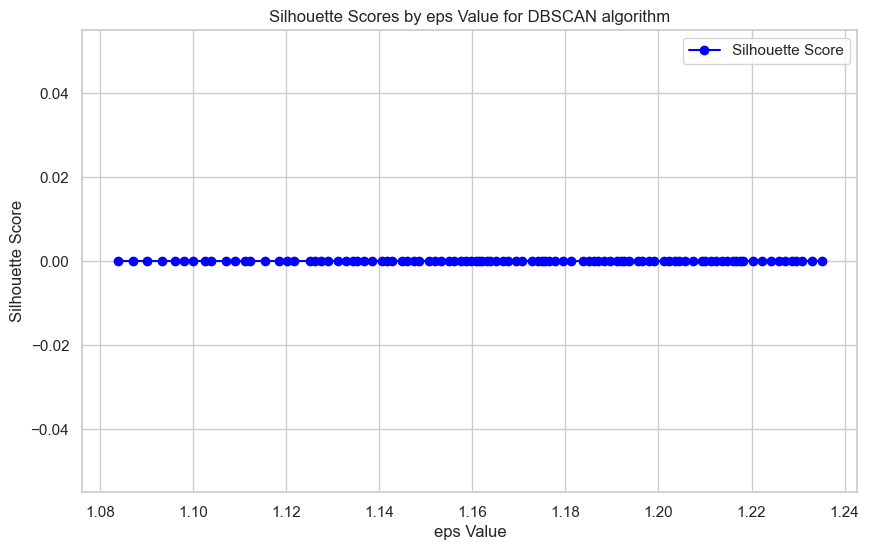

In [30]:
from clustering_algorithms.dbscan import generate_eps_values_via_nearest_neighbors, calc_dbscan

# Generate the best eps values based on the distance of the dataset
eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_tfidf, num_values=100)

# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_tfidf, kappa_dbscan_tfidf, scores_dbscan_tfidf = calc_dbscan(transformed_data_news_tfidf, eps_values)

#### USING FASTTEXT VECTORIZATION

Suggested eps values:[0.01674839 0.01685766 0.01709097 0.01715278 0.01736742 0.017478
 0.01760425 0.01766995 0.01776997 0.01789351 0.01799958 0.0181775
 0.01825249 0.01836836 0.01846593 0.01854909 0.01861766 0.0187883
 0.01884829 0.01901204 0.0191505  0.01926596 0.01938464 0.01944985
 0.01953625 0.01964393 0.0197191  0.01987686 0.01997298 0.02015237
 0.0202366  0.02037243 0.02044862 0.02056109 0.02067212 0.02082226
 0.02089162 0.02108775 0.0211949  0.0213111  0.0213928  0.02156386
 0.02167253 0.02177446 0.02189753 0.02207539 0.02226427 0.02238355
 0.02251322 0.02255815 0.02268564 0.02275752 0.02280506 0.02291024
 0.02300365 0.02307382 0.02320731 0.02327054 0.02343678 0.02352811
 0.02365736 0.02371284 0.02378293 0.02393082 0.02406294 0.02419991
 0.02433877 0.02438019 0.02455997 0.02472277 0.02483994 0.02491746
 0.02497936 0.025134   0.02526493 0.02539545 0.02550696 0.02558245
 0.02567343 0.02585809 0.02605435 0.02627814 0.02648001 0.02668546
 0.02686302 0.02706829 0.02733127 0.02740799 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.52it/s]


The optimal eps based on Silhouette score is: 0.016748389415442943
The number of clusters for optimal eps is: 1


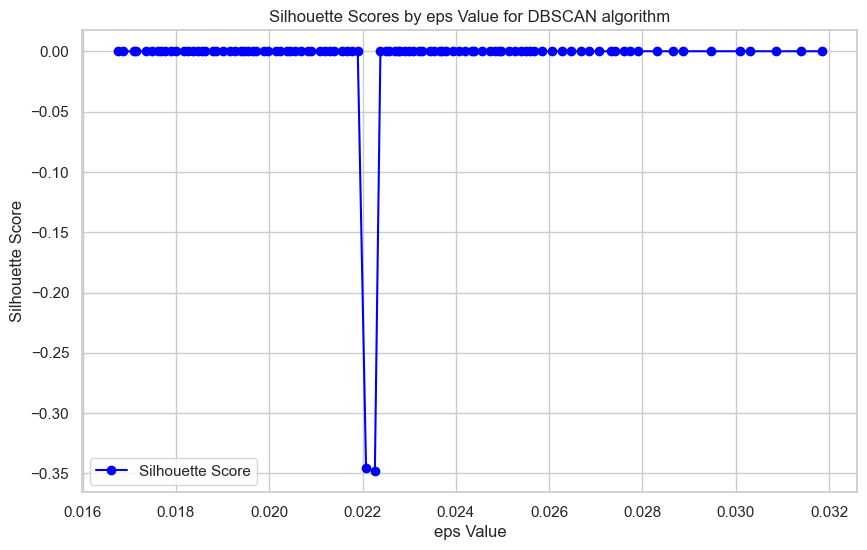

In [31]:
# Generate the best eps values based on the distance of the dataset
eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_fasttext, num_values=100)

# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using FastText
optimal_eps_ft, kappa_dbscan_ft, scores_dbscan_ft = calc_dbscan(transformed_data_news_fasttext, eps_values)

### 5TH CLUSTERING TECHNIQUE: hDBSCAN (HIERARCHICAL DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING TF-IDF VECTORIZATION

In [9]:
from clustering_algorithms.hdbscan import calc_hdbscan

maximum_cluster_size_values = [i for i in range(5, 105, 5)]
# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_hdbscan_tfidf, kappa_hdbscan_tfidf, scores_hdbscan_tfidf = calc_hdbscan(transformed_data_news_tfidf, maximum_cluster_size_values)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16it/s]


NameError: name 'min_cluster_size_values' is not defined

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
